In [1]:
import sys, os
from pathlib import Path

## imports

In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, Trainer, TrainingArguments
from datasets import load_dataset

In [4]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig

In [5]:
from transformers import AutoModelForCausalLM

In [6]:
torch.cuda.empty_cache()

## config

In [7]:
hf_ds = "NSTiwari/DocumentIDEFICS_QA"

In [8]:
# hf_ds = "HuggingFaceM4/DocumentVQA"

In [9]:
hf_model = 'microsoft/Florence-2-base'

In [10]:
img_sz_view = (360, 480)

In [11]:
DEVICE = device = "cuda:0"
USE_LORA = False
USE_QLORA = True

## ds

In [39]:
train_dataset = load_dataset(hf_ds, split="train")
eval_dataset = load_dataset(hf_ds, split="test")

In [40]:
print(train_dataset[1])

{'id': 'train_1', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1606x2104 at 0x7F5D54DD1490>, 'query': 'Who is in  cc in this letter?', 'answers': "['T.F. Riehl']"}


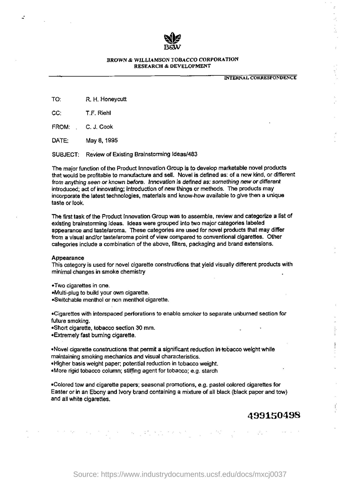

In [41]:
train_dataset[1]['image'].resize(img_sz_view)

## model

In [15]:
processor = AutoProcessor.from_pretrained(hf_model, trust_remote_code=True)

/home/ajkdrag/workspace/projects/object-detection-impl/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
model = AutoModelForCausalLM.from_pretrained(hf_model, trust_remote_code=True)#, quantization_config=bnb_config)

In [17]:
torch.cuda.empty_cache()

In [18]:
_ = model.eval().to(DEVICE)

In [19]:
def run_example(task_prompt, text_input, image):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

In [20]:
eval(train_dataset[0]["answers"])[0]

'1/8/93'

{'<VQA>': 'QA>what to Peggy Carter, PR, 16 Reynolds Building'}


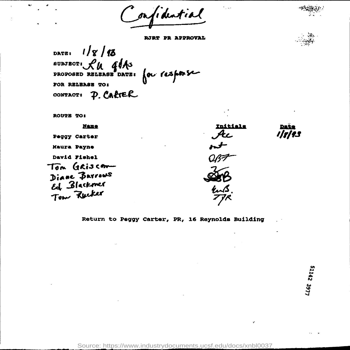

{'<VQA>': 'QA>Who is in.cc.'}


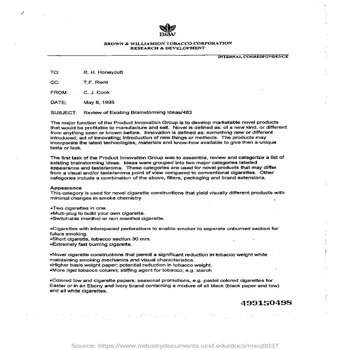

{'<VQA>': 'QA>what is the subject of<poly><loc_141><loc_677><loc_375><loc_677><loc_375><loc_691><loc_141><loc_691></poly>'}


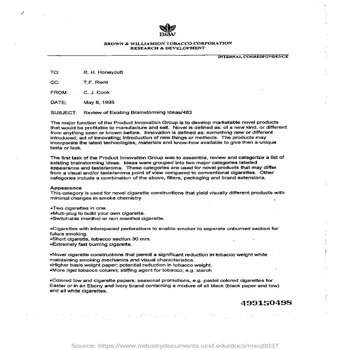

In [21]:
for idx in range(3):
  print(run_example("<VQA>", train_dataset[idx]['query'], train_dataset[idx]['image']))
  display(train_dataset[idx]['image'].resize([350, 350]))

In [54]:
def custom_collate_fn(batch, tokenizer):
    questions = [item['query'] for item in batch]
    answers = [eval(item['answers'])[0] for item in batch]
    images = [item['image'].convert("RGB") for item in batch]

    # Process inputs
    inputs = tokenizer(text=questions, images=images, padding=True, truncation=True, return_tensors="pt")
    
    # Process labels
    labels = tokenizer.tokenizer(text=answers, padding=True, truncation=True, return_tensors="pt").input_ids

    # Add labels to inputs
    inputs['labels'] = labels

    return inputs

In [23]:
def custom_map_fn(batch):
    answers = [eval(item)[0] for item in batch["answers"]]
    
    # Process inputs
    inputs = processor(text=batch['query'], images=batch["image"], padding=True, truncation=True, return_tensors="pt", do_convert_rgb=True)
    
    # Process labels
    labels = processor.tokenizer(text=answers, padding=True, truncation=True, return_tensors="pt").input_ids

    # Add labels to inputs
    inputs['labels'] = labels

    return inputs

In [24]:
eval_dataset = eval_dataset.map(custom_map_fn, batched=True,  batch_size=50, remove_columns=eval_dataset.features.keys())

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [25]:
eval_dataset.save_to_disk("../datastet_ckpt/eval")

Saving the dataset (0/3 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

In [26]:
torch.cuda.empty_cache()

In [27]:
train_dataset = train_dataset.map(custom_map_fn, batched=True, batch_size=50, remove_columns=train_dataset.features.keys())

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [28]:
train_dataset.save_to_disk("../datastet_ckpt/train")

Saving the dataset (0/15 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [29]:
train_dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])

## train

In [46]:
from functools import partial

In [47]:
from torch.utils.data import DataLoader

In [48]:
from transformers import Trainer, TrainingArguments

In [49]:
epochs = 5
lr=1e-6

In [63]:
training_args = TrainingArguments(
        output_dir="./model_checkpoints",
        num_train_epochs=epochs,
        per_device_train_batch_size=1,  # Adjust based on your GPU memory
        per_device_eval_batch_size=1,
        learning_rate=lr,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=50,
        eval_strategy="steps",
        save_strategy="epoch",
        # load_best_model_at_end=True,
        push_to_hub=False,
        remove_unused_columns=False,
        # use_cpu=True
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [64]:
for param in model.vision_tower.parameters():
    param.is_trainable = False

In [65]:
trainer = Trainer(
        model=model,#.cpu(),
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=partial(custom_collate_fn, tokenizer=processor)
)


In [66]:
first_batch = next(iter(trainer.get_train_dataloader()))

In [67]:
processor.decode(first_batch["input_ids"][0])

'<s>What is the heading of the document?</s>'

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
50,3.060500,2.872840
100,2.547700,2.300458
150,2.263200,2.209368
200,2.548100,2.182669
250,2.001600,2.148309
300,2.134000,2.106442
350,1.844900,2.028750
400,1.722100,2.063179
450,1.570500,2.063223
500,1.776800,2.012255


In [70]:
import gc
gc.collect()

5618

In [71]:
torch.cuda.empty_cache()